In [50]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
# from fa2 import ForceAtlas2
from Functions import DataCollection, DataCleaning, GetRatings, GetConnectedMoviesArtist, Plots
from imdb import IMDb
import powerlaw
import math

# Warning to ignore
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

# **Data**
---

In [51]:
df_movies = pd.read_json('df_all.json', orient='table')
df_movies

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel,DirectorIMDb,AirDate,Countries,BoxOffice
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29,3.3,Low,"[Barbara Bialowas, Tomasz Mandes]",07 Feb 2020,[Poland],9458590.0
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29,6.3,Moderate,[Patrick Vollrath],26 Dec 2019,"[Germany, Austria, United States, France]",NaN
2,Archenemy,adam egypt mortimer,"joe manganiello,skylan brooks, zolee griggs,pa...",mix,Action,2020,Archenemy_(film),20-29,5.0,Low,[Adam Egypt Mortimer],11 Dec 2020,[United States],NaN
3,Asuraguru,araajdheep,"vikram prabhu,mahima nambiar,subbaraju,yogi babu",india,Action,2020,Asuraguru,20-29,3.3,Low,[A. Rajdeep],11 Mar 2020,[India],NaN
4,Aswathama,ramana teja,"naga shourya,mehreen pirzada",india,Action,2020,Aswathama_(film),20-29,6.4,Moderate,[Ramana Teja],31 Jan 2020,[India],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5242,The Promise,chen kaige,"hiroyuki sanada,jang dong-gun,cecilia cheung",china,Mix,2005,The_Promise_(2005_film),00-09,6.1,Moderate,[Terry George],21 Apr 2017,"[Spain, United States]",NaN
5243,Legend of the Guardians: The Owls of Ga'Hoole,zack snyder,"jim sturgess,joel edgerton,geoffrey rush,hugo ...",mix,Fantasy,2010,Legend_of_the_Guardians:_The_Owls_of_Ga%27Hoole,10-19,6.9,High,[Zack Snyder],04 Nov 2010,"[United States, Australia]",NaN
5244,Lethal,dustin rikert,"heather marie marsden,lorenzo lamas,frank zaga...",united states,Action,2004,Lethal_(film),00-09,7.8,High,NaN,NaN,[United States],NaN
5245,Piranha 3D,alexandre aja,"elisabeth shue,adam scott,jerry o'connell",united states,Mix,2010,Piranha_3-D,10-19,5.5,Moderate,[Alexandre Aja],07 Oct 2010,"[France, United States, Japan]",NaN


In [52]:
df_movies["Cast"][df_movies["Title"]=="Avengers: Endgame"].iloc[0]

'robert downey jr,chris evans,chris hemsworth,scarlett johansson,mark ruffalo,jeremy renner,brie larson,paul rudd,karen page,josh brolin'

In [53]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
two_colors = colorpalette[::8][0:2]
three_ratings_colors = colorpalette[::17][0:3]
three_different_colors = colorpalette[::10][0:3]
genre_colors = colorpalette[::7][0:8]

hex_colors_genre = ['#1d068d', '#6700a7', '#a51f97', '#d3516f', '#f38649', '#fdc427', '#ecd54a', '#bcae6b']

# **Connected movies**
---

# **Basic Statistics**
---

In [54]:
def plot_bar(data_counts, column_string, cmap_string, title, x_data, y_data, x_label, y_label, ):
    # Colors
    num_unique = data_counts[column_string].nunique()
    cmap = cm.get_cmap(cmap_string)  # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    colors = [cmap(i) for i in np.linspace(0, 1, num_unique)]
    
    # Bar plot
    sns.set(style="whitegrid") 
    plt.figure(figsize=(20, 7)) 
    barplot = sns.barplot(x=x_data, y=y_data, data=data_counts, palette=colors)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(title, fontsize=25, fontweight="bold")
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

    # Add count numbers on each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points',
                        fontsize=14)
    plt.show()

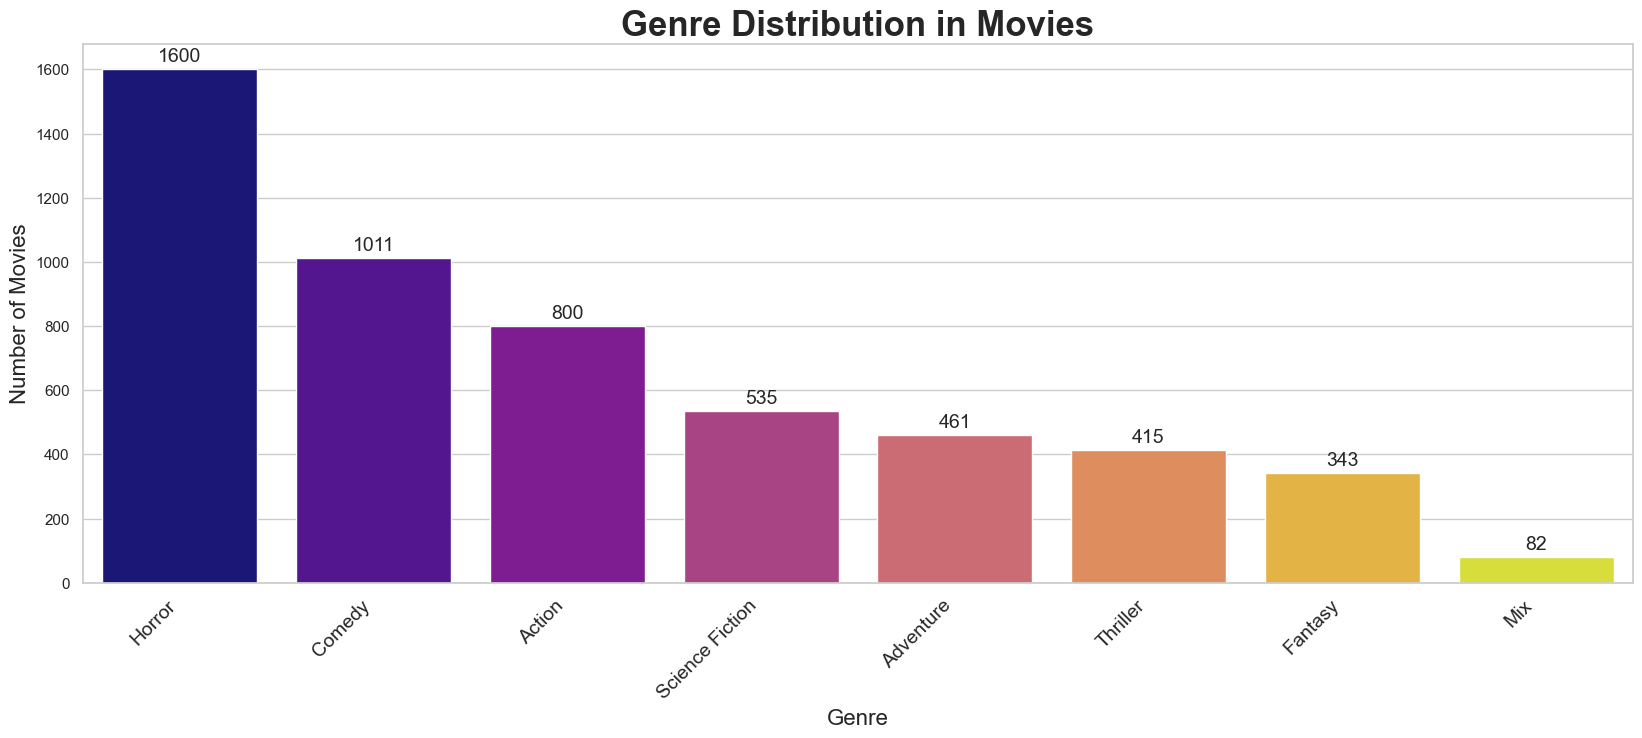

In [55]:
genre_counts = df_movies['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']

plot_bar(data_counts = genre_counts,
         column_string = "Genre",
         cmap_string = "plasma",
         title = "Genre Distribution in Movies",
         x_data = "Genre",
         y_data = "Count",
         x_label = "Genre",
         y_label = "Number of Movies")

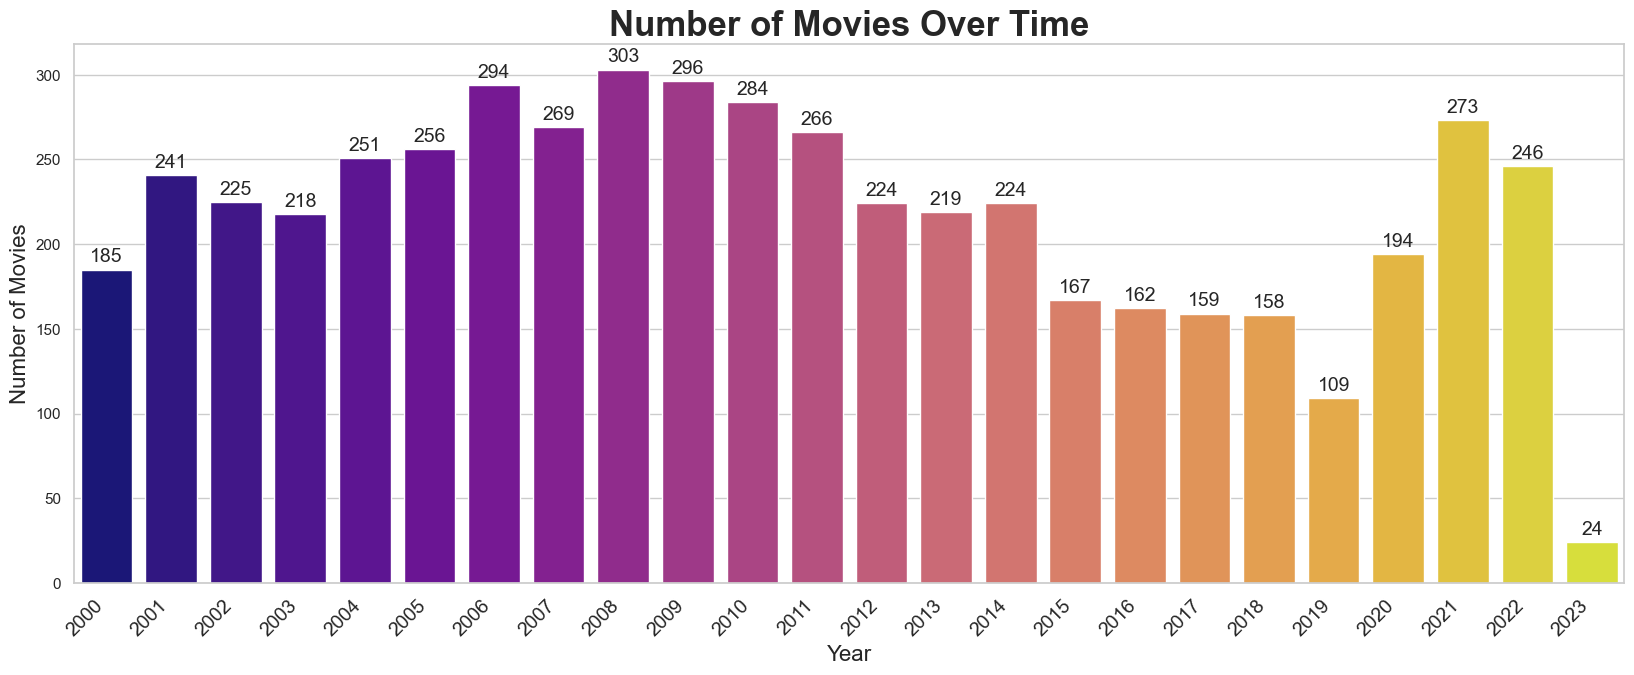

In [56]:
df_movies['Year'] = pd.to_numeric(df_movies['Year'], errors='coerce')
movies_per_year = df_movies.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']

plot_bar(data_counts = movies_per_year,
         column_string = "Year",
         cmap_string = "plasma",
         title = "Number of Movies Over Time",
         x_data = "Year",
         y_data = "Number of Movies",
         x_label = "Year",
         y_label = "Number of Movies")

## **Rating distribution**

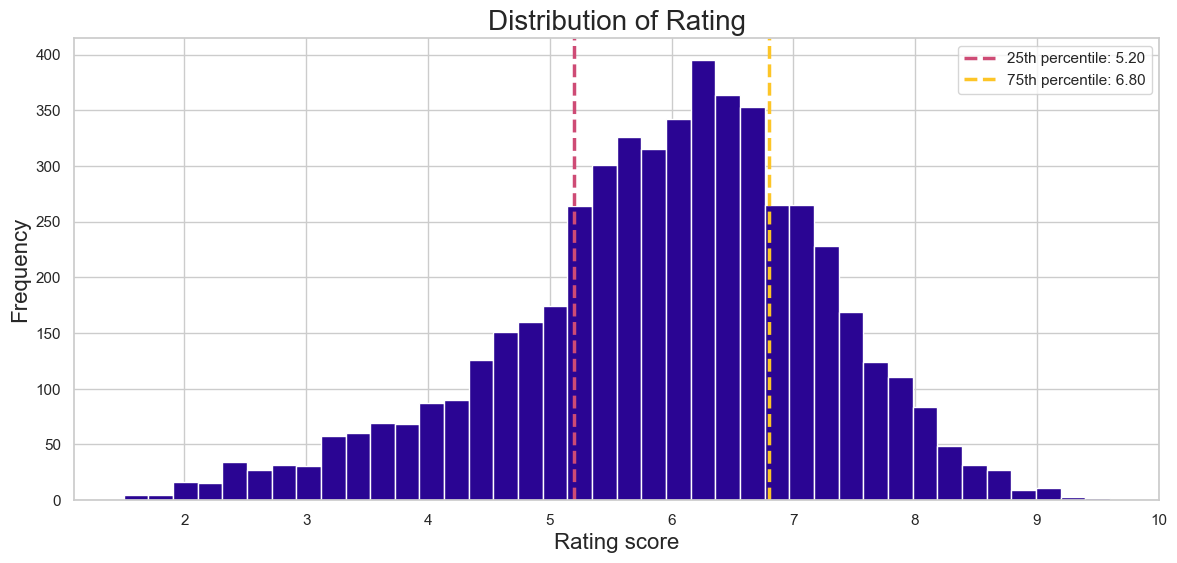

In [57]:
# Histogram
plt.figure(figsize=(14,6))
plt.hist(list(df_movies['Rating'].values), bins=40, edgecolor='white', color=colorpalette[1])
plt.xlabel('Rating score', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Distribution of Rating', fontsize=20)

# Add vertical lines for mean and median
percentile_25 = np.percentile(list(df_movies['Rating'].values), 25)
percentile_75 = np.percentile(list(df_movies['Rating'].values), 75)
plt.axvline(percentile_25, color=colorpalette[20], linestyle="dashed", linewidth=2.5, label=f"25th percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color=colorpalette[35], linestyle="dashed", linewidth=2.5, label=f"75th percentile: {percentile_75:.2f}")
plt.legend()
plt.show()

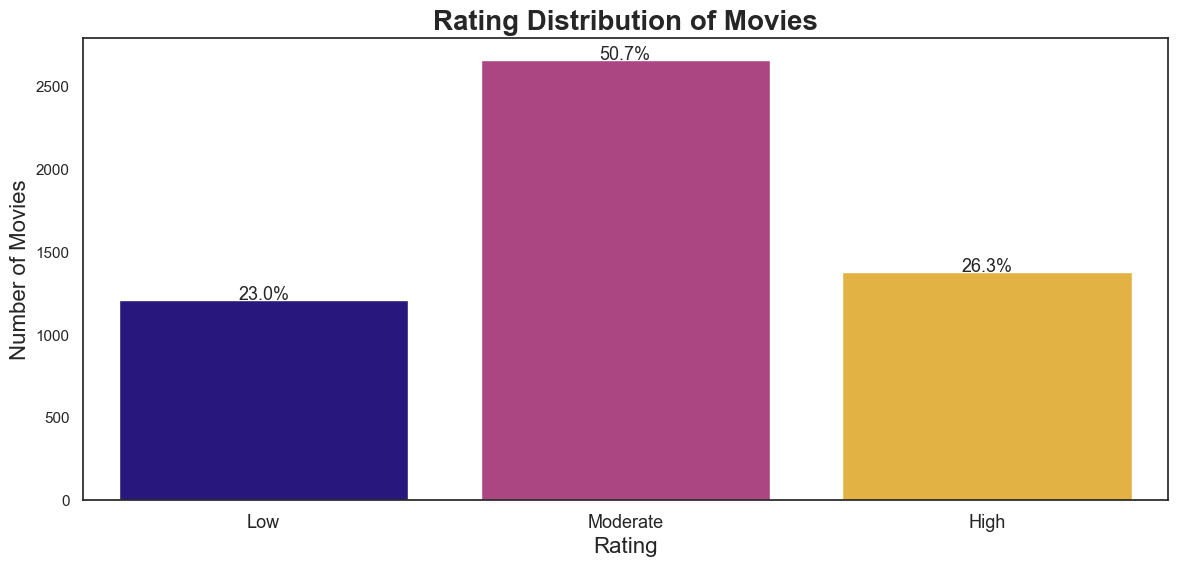

In [58]:
rating_counts = df_movies['RatingLabel'].value_counts()
rating_counts = rating_counts.reset_index()
rating_counts.columns = ['RatingLabel', 'Count']
ordered_labels = ['Low', 'Moderate', 'High']
rating_counts['RatingLabel'] = pd.Categorical(rating_counts['RatingLabel'], categories=ordered_labels, ordered=True)
rating_counts = rating_counts.sort_values('RatingLabel')

plots = Plots()
plots.plot_bar(x = 'RatingLabel', y = 'Count', data = rating_counts, title = 'Rating Distribution of Movies', 
         xlabel= 'Rating', ylabel= 'Number of Movies', figsize=(14,6), 
         color_palette=three_ratings_colors, order=None)

# **Network**
---

In [59]:
with open('connected_movies_and_artists.json', 'r') as file:
    connected_movies = json.load(file)

# connected_movies

## **Creating the network**

In [60]:
G_movies = nx.Graph()

# Add nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies[['Title','Director','Cast','Country','Genre', 'RatingLabel',
                'Year', 'Decade']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        weight = len(connected_movies[movie][connected_movie])
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], weight=weight, attribute_name=attribute_value)

In [61]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5247  nodes
The network consist of:  29813  edges


## **Largest Connected Component**

In [62]:
connected_components = nx.connected_components(G_movies)
largest_cc = max(connected_components, key=len)
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [63]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  3874  nodes
The largest connected component network consist of:  29444  edges


In [64]:
# Dataframe with only the movies in the largest connected component
movies_largest_cc = list(G_largest_cc.nodes())
df_movies_largest_cc = df_movies[df_movies['Title'].isin(movies_largest_cc)]

## **Type of network**

In [65]:
degree_sequence = [d for _, d in G_largest_cc.degree()]
fit = powerlaw.Fit(degree_sequence)
exponent = fit.power_law.alpha
print("Exponent of the degree distribution:", exponent)

Calculating best minimal value for power law fit
Exponent of the degree distribution: 8.913367077125251


$\gamma>3$ indicates that this falls into the *random network regime*. This makes the network hard to distinguish from a random network.

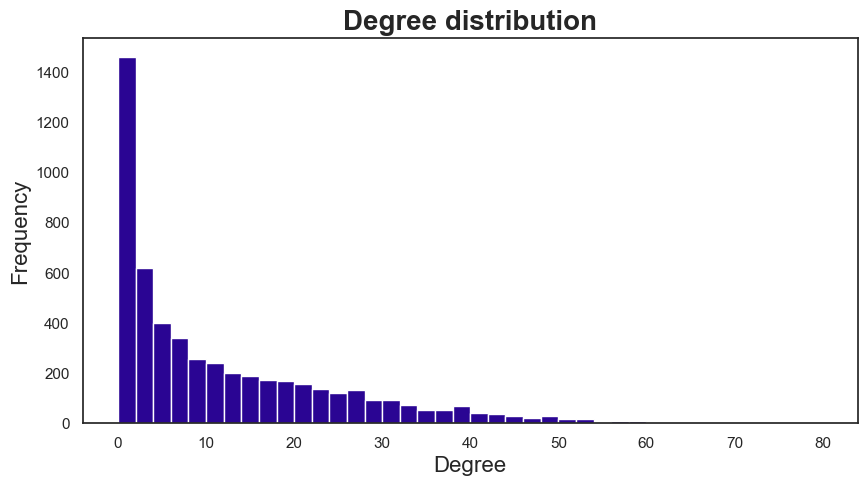

In [89]:
hist_degree, bins_degree = np.histogram(degree_sequence, bins=40) # Returns two arrays
plt.figure(figsize=(10, 5))
bin_midpoints_degree = bins_degree[:-1] + np.diff(bins_degree) / 2
plt.bar(bin_midpoints_degree, hist_degree, width=np.diff(bins_degree), color = colorpalette[1], edgecolor="white", linewidth=1)
plt.xlabel("Degree", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Degree distribution", fontsize=20, fontweight="bold")
plt.show()

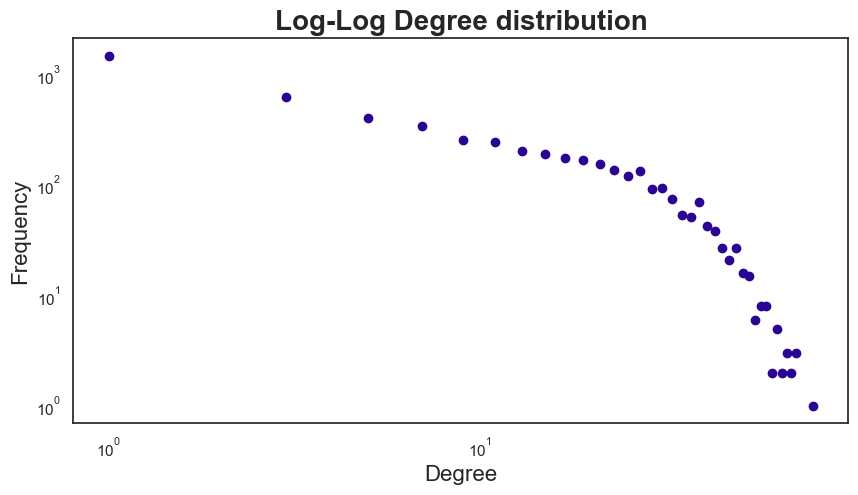

In [88]:
hist_degree, bins_degree = np.histogram(degree_sequence, bins=40)
bin_midpoints_degree = bins_degree[:-1] + np.diff(bins_degree) / 2
plt.figure(figsize=(10, 5))
plt.loglog(bin_midpoints_degree, hist_degree, 'o', color = colorpalette[1])
plt.xlabel("Degree", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Log-Log Degree distribution", fontsize=20, fontweight="bold")
plt.show()

Den er ikke lineær -> Ikke power law
- Exponent bliver hældningskoefficient på den rette linje

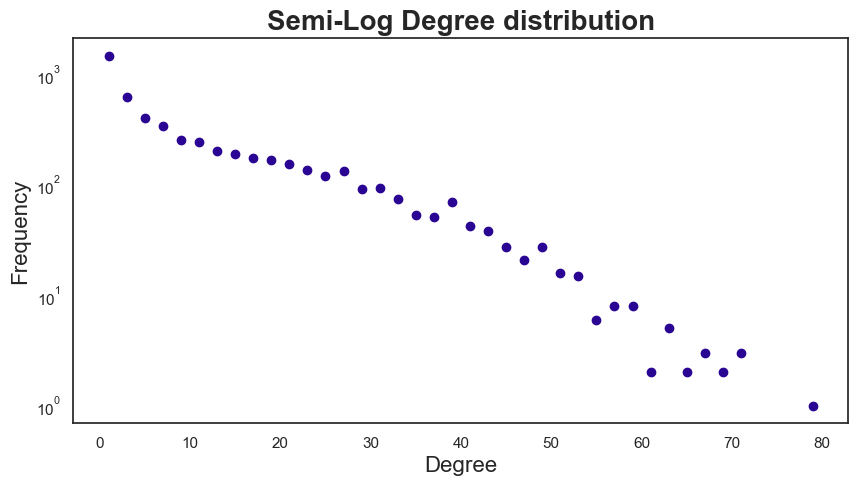

In [91]:
# y=log, x=not
hist_degree, bins_degree = np.histogram(degree_sequence, bins=40)
bin_midpoints_degree = bins_degree[:-1] + np.diff(bins_degree) / 2
plt.figure(figsize=(10, 5))
plt.semilogy(bin_midpoints_degree, hist_degree, 'o', color = colorpalette[1])
plt.xlabel("Degree", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Semi-Log Degree distribution", fontsize=20, fontweight="bold")
plt.show()


## **Degrees analysis**

In [67]:
# df_largest_cc = df_largest_cc.drop(columns='Degree')
df_degree_sequence = pd.DataFrame(list(G_largest_cc.degree()), columns=['Title', 'Degree'])
df_largest_cc_with_degrees = df_movies_largest_cc.merge(df_degree_sequence, on='Title')

# For genre
average_degree_by_genre = df_largest_cc_with_degrees.groupby('Genre')['Degree'].mean()
sorted_average_degree_by_genre = average_degree_by_genre.sort_values(ascending=False)

# For rating
average_degree_by_rating = df_largest_cc_with_degrees.groupby('RatingLabel')['Degree'].mean()
sorted_average_degree_by_rating = average_degree_by_rating.sort_values(ascending=False)

# Print
print(f'Sorted average degree by genre:\n{sorted_average_degree_by_genre}\n')
print(f'Sorted average degree by rating:\n{sorted_average_degree_by_rating}')

Sorted average degree by genre:
Genre
Action             20.067365
Fantasy            19.094545
Adventure          18.600551
Thriller           16.525000
Mix                16.000000
Comedy             15.788095
Science Fiction    15.725061
Horror              7.613408
Name: Degree, dtype: float64

Sorted average degree by rating:
RatingLabel
High        17.991501
Moderate    16.039618
Low          8.655556
Name: Degree, dtype: float64


From the print above, "Fantasy" movies tend to share actors with more other movies on average. This suggests that the genre tend to have larger casts or that actors in these genres tend to work in more movies within the same genre.

Similarly, the sorted average degree by rating shows that movies with a ‘High’ rating tend to share actors with more other movies on average. This could suggest that highly rated movies tend to have actors who work in more movies, or that actors who work in highly rated movies tend to also work in other highly rated movies.

### **Top connected movies**

In [68]:
top_connected_movies = df_degree_sequence.sort_values('Degree', ascending=False)
degree_of_top_10th_connected_movies = top_connected_movies['Degree'].iloc[9]  # Get the degree of the 10th movie
top_10_connected_movies = top_connected_movies[top_connected_movies['Degree'] >= degree_of_top_10th_connected_movies]
top_10_connected_movies

,Title,Degree
3703,The Avengers,80
691,x Xx: Return of Xander Cage,71
679,The Fate of the Furious,71
3503,Into the Woods,71
2931,Gnomeo and Juliet,69
447,The Hitman's Wife's Bodyguard,69
721,Hobbs & Shaw,67
3458,GI Joe: Retaliation,67
1968,Alexander,66
896,Tropic Thunder,65


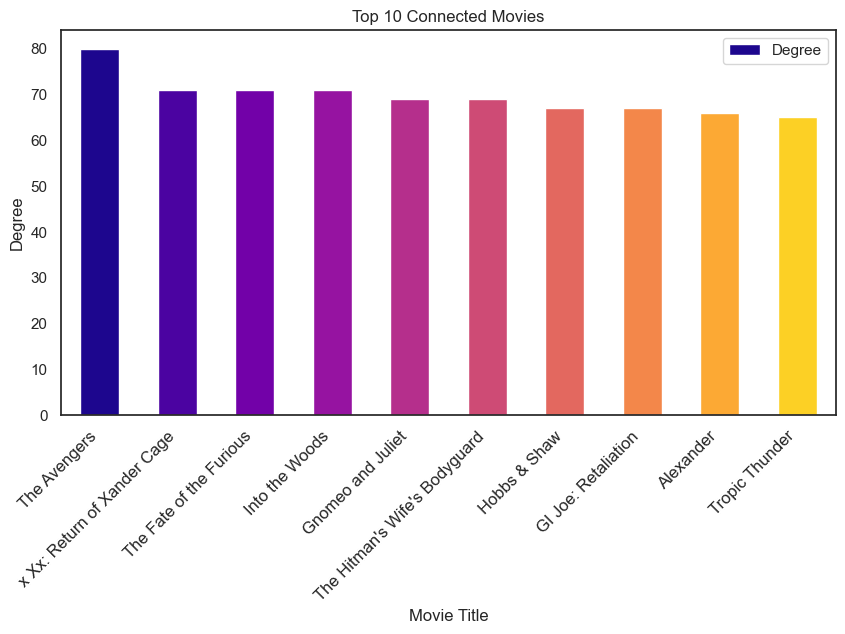

In [69]:
top_10_connected_movies.plot.bar(x="Title", y="Degree", color = colorpalette[::4], figsize=(10, 5))
plt.title("Top 10 Connected Movies")
plt.xlabel("Movie Title")
plt.ylabel("Degree")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.show()

In [70]:
top_10_movies_details = pd.merge(top_10_connected_movies, df_movies, on='Title', how='left')
top_10_movies_details

,Title,Degree,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel,DirectorIMDb,AirDate,Countries,BoxOffice
0,The Avengers,80,joss whedon,"robert downey jr,chris evans,scarlett johansso...",united states,Adventure,2012,The_Avengers_(2012_film),10-19,8.0,High,[Joss Whedon],26 Apr 2012,[United States],NaN
1,x Xx: Return of Xander Cage,71,d j caruso,"vin diesel,samuel l jackson,donnie yen",united states,Action,2017,XXx:_Return_of_Xander_Cage,10-19,5.2,Moderate,[D.J. Caruso],19 Jan 2017,"[China, Canada, United States]",NaN
2,The Fate of the Furious,71,f gary gray,"vin diesel,dwayne johnson,jason statham",united states,Action,2017,The_Fate_of_the_Furious,10-19,6.6,Moderate,[F. Gary Gray],13 Apr 2017,"[China, Japan, United States]",NaN
3,Into the Woods,71,rob marshall,"anna kendrick,chris pine,emily blunt,meryl str...",united states,Adventure,2014,Into_the_Woods_(2014_film),10-19,5.9,Moderate,[Rob Marshall],26 Mar 2015,[United States],NaN
4,Gnomeo and Juliet,69,kelly asbury,"james mc avoy,emily blunt,jason statham,maggie...",united kingdom,Fantasy,2011,Gnomeo_and_Juliet,10-19,5.9,Moderate,[Kelly Asbury],10 Mar 2011,"[United Kingdom, Canada, United States]",NaN
5,The Hitman's Wife's Bodyguard,69,patrick hughes,"ryan reynolds,samuel l jackson,salma hayek,fra...",united states,Action,2021,The_Hitman%27s_Wife%27s_Bodyguard,20-29,6.1,Moderate,[Patrick Hughes],15 Jul 2021,"[United Kingdom, United States, Sweden, Bulgar...",NaN
6,Hobbs & Shaw,67,david leitch,"jason statham,dwayne johnson,idris elba",united states,Action,2019,Hobbs_%26_Shaw,10-19,6.5,Moderate,[David Leitch],01 Aug 2019,"[United States, Japan]",NaN
7,GI Joe: Retaliation,67,jon m chu,"dwayne johnson,channing tatum,bruce willis",united states,Science Fiction,2013,G.I._Joe:_Retaliation,10-19,5.7,Moderate,[Jon M. Chu],28 Mar 2013,[United States],NaN
8,Alexander,66,oliver stone,"colin farrell,angelina jolie,val kilmer,rosari...",mix,Adventure,2004,Alexander_(2004_film),00-09,5.6,Moderate,[Oliver Stone],26 Nov 2004,"[United States, United Kingdom, Germany, Nethe...",NaN
9,Tropic Thunder,65,ben stiller,"ben stiller,robert downey jr,jack black,jay ba...",united states,Action,2008,Tropic_Thunder,00-09,7.1,High,[Ben Stiller],10 Oct 2008,"[United States, United Kingdom, Germany]",NaN


In [71]:
# top_10_movies_details.describe()

In [72]:
print(top_10_movies_details['Genre'].value_counts())

Genre
Action             5
Adventure          3
Fantasy            1
Science Fiction    1
Name: count, dtype: int64


In [73]:
print(top_10_movies_details['Decade'].value_counts())
# Newer movies are more connected

Decade
10-19    7
00-09    2
20-29    1
Name: count, dtype: int64


In [74]:
print(top_10_movies_details['RatingLabel'].value_counts())

RatingLabel
Moderate    8
High        2
Name: count, dtype: int64


In [75]:
print(top_10_movies_details['Director'].unique())

['joss whedon' 'd j caruso' 'f gary gray' 'rob marshall' 'kelly asbury'
 'patrick hughes' 'david leitch' 'jon m chu' 'oliver stone' 'ben stiller']


In [76]:
# top_10_movies_details_print = top_10_movies_details.sort_values(by='Rating', ascending=False)
# print(top_10_movies_details_print)

In [77]:
# test = df_movies.sort_values(by='Rating', ascending=False)
# print(test)

## **Top connected movies in each genre**

C:\Users\mydun\AppData\Local\Temp\ipykernel_23852\722035869.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


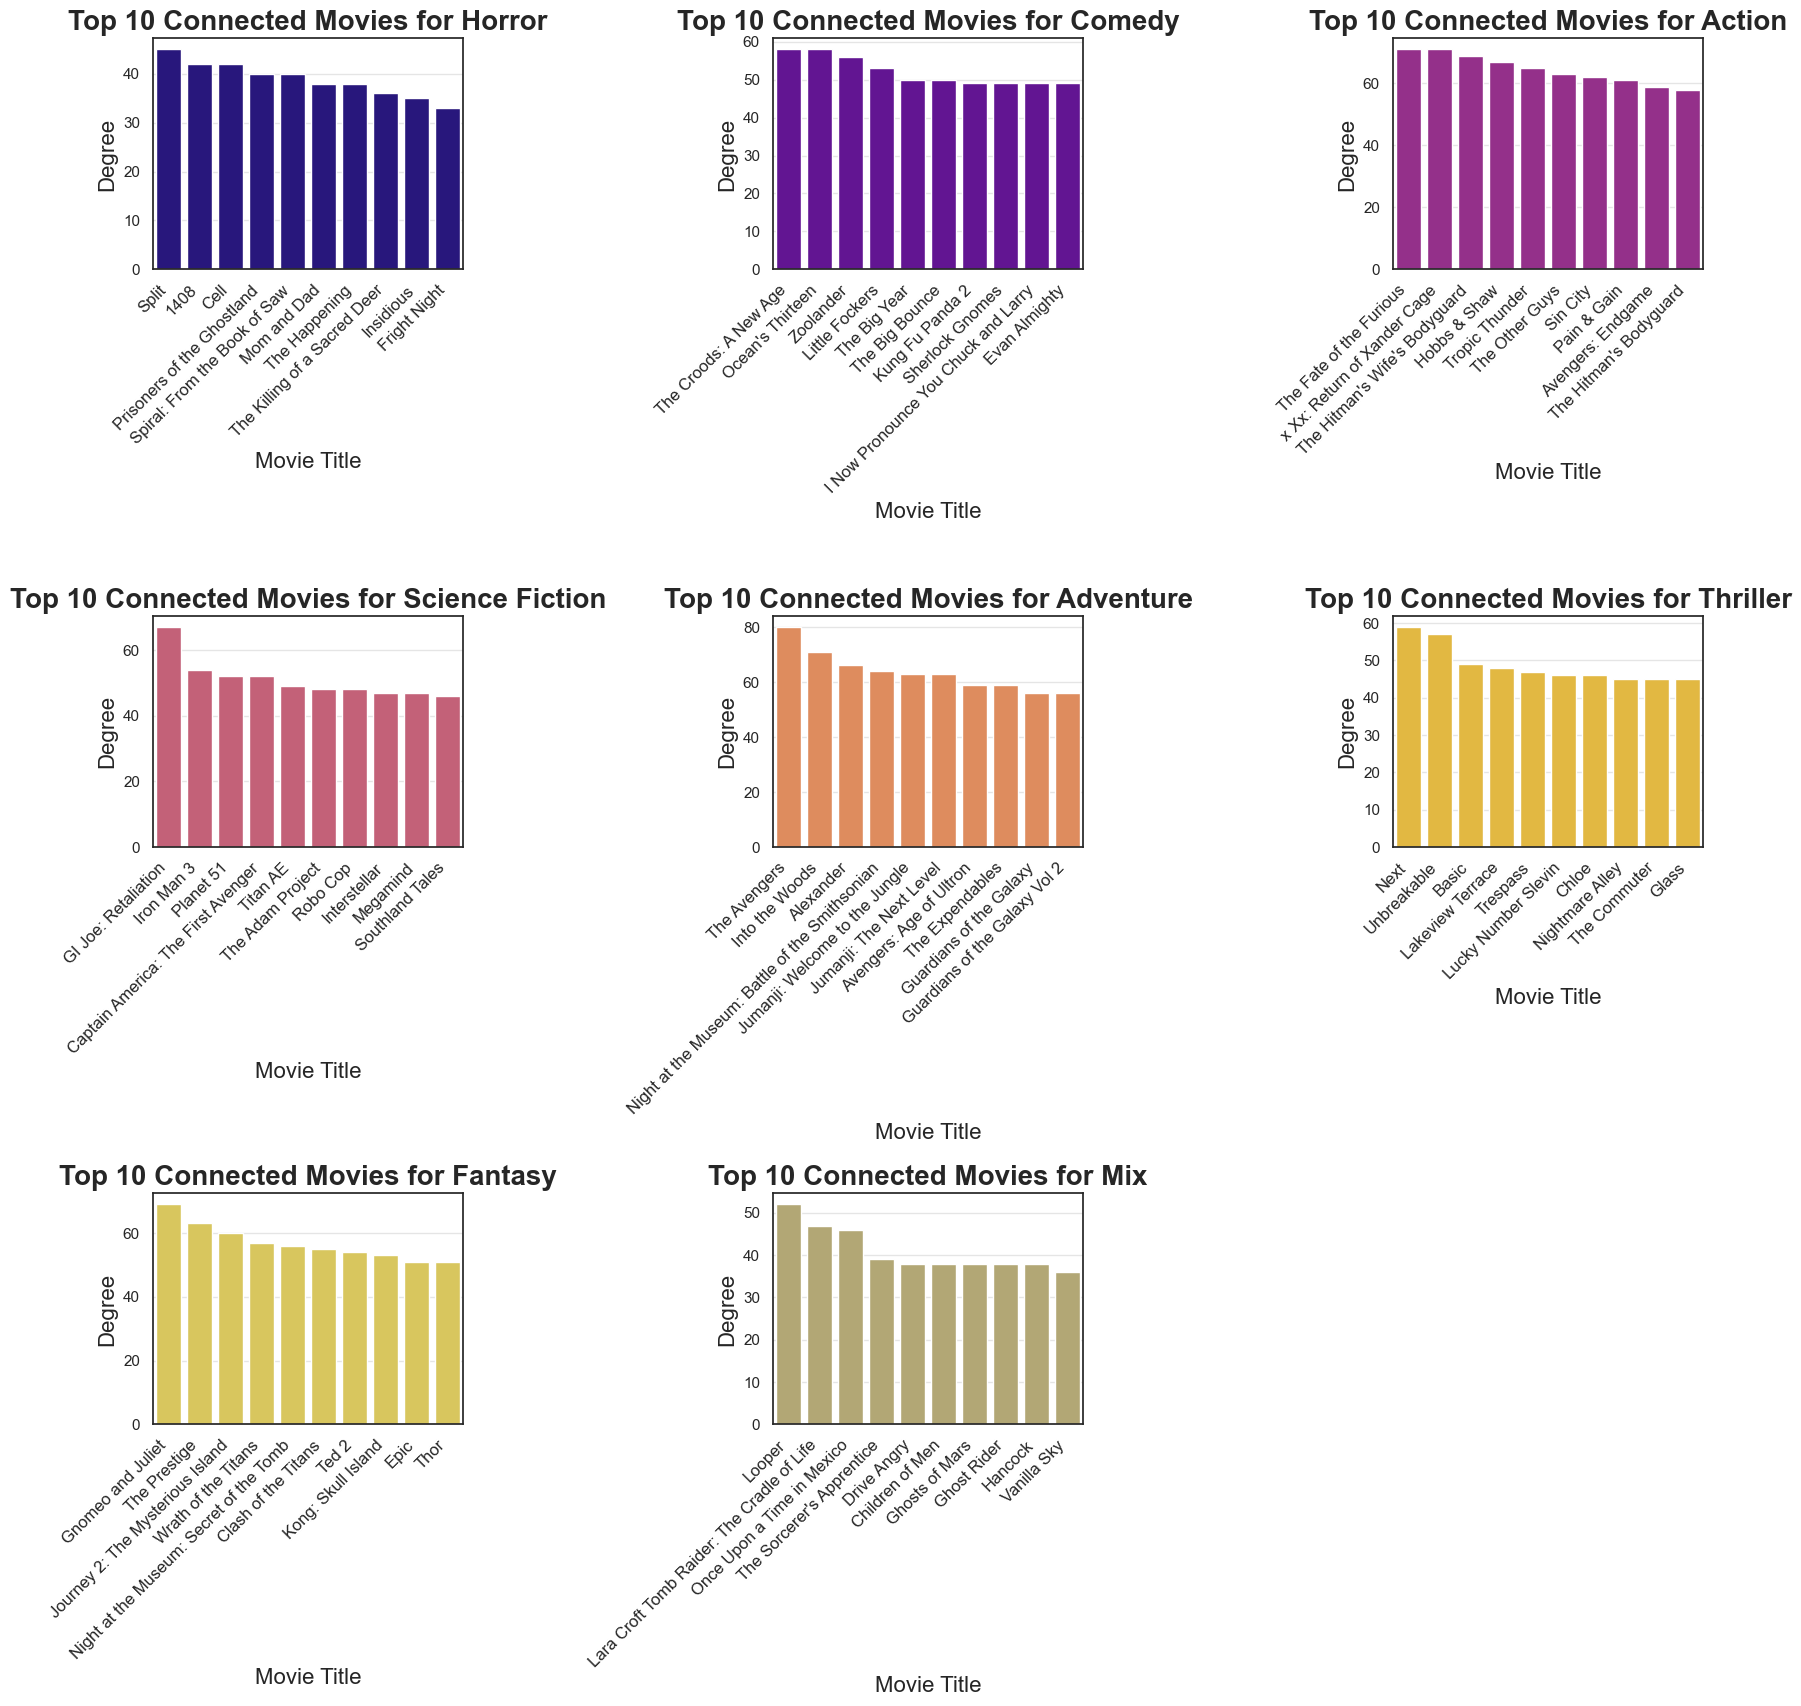

In [78]:
# Make plot for each genre
ordered_genres = df_movies['Genre'].value_counts().index
genre_color_dict = dict(zip(ordered_genres, hex_colors_genre))

# Figure properties
ncolumns = 3
nrows = math.ceil(len(ordered_genres) / ncolumns)
fig, axs = plt.subplots(nrows, ncolumns, figsize=(20, 6*nrows), gridspec_kw={'wspace': 1, 'hspace': 1.5})

for i, genre in enumerate(ordered_genres):
    # Top 10 movies of the genre
    top_movies = df_largest_cc_with_degrees[df_largest_cc_with_degrees["Genre"] == genre].nlargest(10, "Degree")
    
    # Bar plot
    sns.barplot(x="Title", y="Degree", data=top_movies, ax=axs[i//ncolumns, i%ncolumns], color=genre_color_dict[genre])
    axs[i//ncolumns, i%ncolumns].set_title(f"Top 10 Connected Movies for {genre}", fontsize=20, fontweight="bold")
    axs[i//ncolumns, i%ncolumns].set_xticklabels(axs[i//ncolumns, i%ncolumns].get_xticklabels(), rotation=45, ha="right", fontsize=12)
    axs[i//ncolumns, i%ncolumns].set_xlabel("Movie Title", fontsize=16)
    axs[i//ncolumns, i%ncolumns].set_ylabel("Degree", fontsize=16)
    # axs[i//3, i%3].set_xlabel('')
    # axs[i//3, i%3].text(1.2, -0.05, 'Movie Title', verticalalignment='bottom', horizontalalignment='right', transform=axs[i//3, i%3].transAxes)
    axs[i//ncolumns, i%ncolumns].grid(True, linestyle="-", alpha=0.5, axis="y")

# Remove empty subplots
if len(ordered_genres) % ncolumns != 0:
    for j in range(len(ordered_genres) % ncolumns, ncolumns):
        fig.delaxes(axs[nrows-1, j])

plt.tight_layout()
plt.show()


### **Degree centrality**

In [79]:
# Degree centrality
degree_centrality = nx.degree_centrality(G_largest_cc)
df_degree_centrality = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['Degree Centrality'])
top_10_movies_degree_centrality = df_degree_centrality.sort_values('Degree Centrality', ascending=False).head(10)
print(top_10_movies_degree_centrality)


                               Degree Centrality
The Avengers                            0.020656
x Xx: Return of Xander Cage             0.018332
The Fate of the Furious                 0.018332
Into the Woods                          0.018332
Gnomeo and Juliet                       0.017816
The Hitman's Wife's Bodyguard           0.017816
Hobbs & Shaw                            0.017299
GI Joe: Retaliation                     0.017299
Alexander                               0.017041
Tropic Thunder                          0.016783


Degree centrality = Number of direct connections a node has in the network.
- High degree centrality = many connections to other movies. -> The cast is widely represented across the network.

### **Betweenness centrality**

In [80]:
# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_largest_cc)
df_betweenness_centrality = pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['Betweenness Centrality'])
top_10_movies_betweenness_centrality = df_betweenness_centrality.sort_values('Betweenness Centrality', ascending=False).head(10)
print(top_10_movies_betweenness_centrality)
# Approx 1.10 min

                              Betweenness Centrality
x Xx: Return of Xander Cage                 0.026390
Baywatch                                    0.020363
Kate                                        0.019748
Snowpiercer                                 0.015962
Grasshopper                                 0.014798
The Seaside Motel                           0.012954
The Good, the Bad, the Weird                0.012686
Krrish                                      0.012636
Hellblazers                                 0.011841
Ashfall                                     0.011821


Betweenness centrality = Measure of a node's centrality in the network, based on the number of shortest paths that pass through the node.
- High betweenness centrality = A movie that connects many pairs of movies -> These movies might not have the largest casts, but they have key actors who link together otherwise disconnected groups of movies.

### **Eigenvector centrality**

In [81]:
# Eigenvector centrality
eigenvector_centrality = nx.eigenvector_centrality(G_largest_cc)
df_eigenvector_centrality = pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['Eigenvector Centrality'])
top_10_movies_eigenvector_centrality = df_eigenvector_centrality.sort_values('Eigenvector Centrality', ascending=False).head(10)
print(top_10_movies_eigenvector_centrality)

                               Eigenvector Centrality
The Fate of the Furious                      0.129846
The Avengers                                 0.124328
x Xx: Return of Xander Cage                  0.120272
Hobbs & Shaw                                 0.115755
Unbreakable                                  0.113464
GI Joe: Retaliation                          0.112490
The Hitman's Wife's Bodyguard                0.110737
The Hitman's Bodyguard                       0.107722
Furious 7                                    0.104107
Fast & Furious 6                             0.104107


Eigenvector centrality = Measure of influence of a node in a network.
- High eigenvector centrality = A movie that is connected to other highly connected movies. -> A movie with high eigenvector centrality may not have the most number of common actors, but it is connected to other movies that do. This could suggest that the movie shares actors with a number of influential or popular movies.

# **Directors**
---

In [82]:
df_movies_exploded = df_movies.explode('DirectorIMDb')
num_unique_directors = df_movies_exploded['DirectorIMDb'].nunique()
print("Number of unique directors:", num_unique_directors)

Number of unique directors: 3422


In [83]:
# Frequency of each director
# director_counts = df_movies['Director'].value_counts()
# director_counts
director_frequency = df_movies_exploded['DirectorIMDb'].value_counts()
# director_frequency

In [84]:
# Get all directors with frequency greater than or equal to the 10th director's frequency
tenth_director_frequency = director_frequency.nlargest(10).iloc[-1]
top_directors = director_frequency[director_frequency >= tenth_director_frequency]
top_directors

DirectorIMDb
Robert Rodriguez      14
Shawn Levy            13
Tim Burton            12
Ridley Scott          12
Takashi Miike         11
Doug Liman            10
Guillermo del Toro    10
Peter Jackson         10
Johannes Roberts      10
David DeCoteau        10
Zack Snyder           10
Steven Soderbergh     10
Name: count, dtype: int64

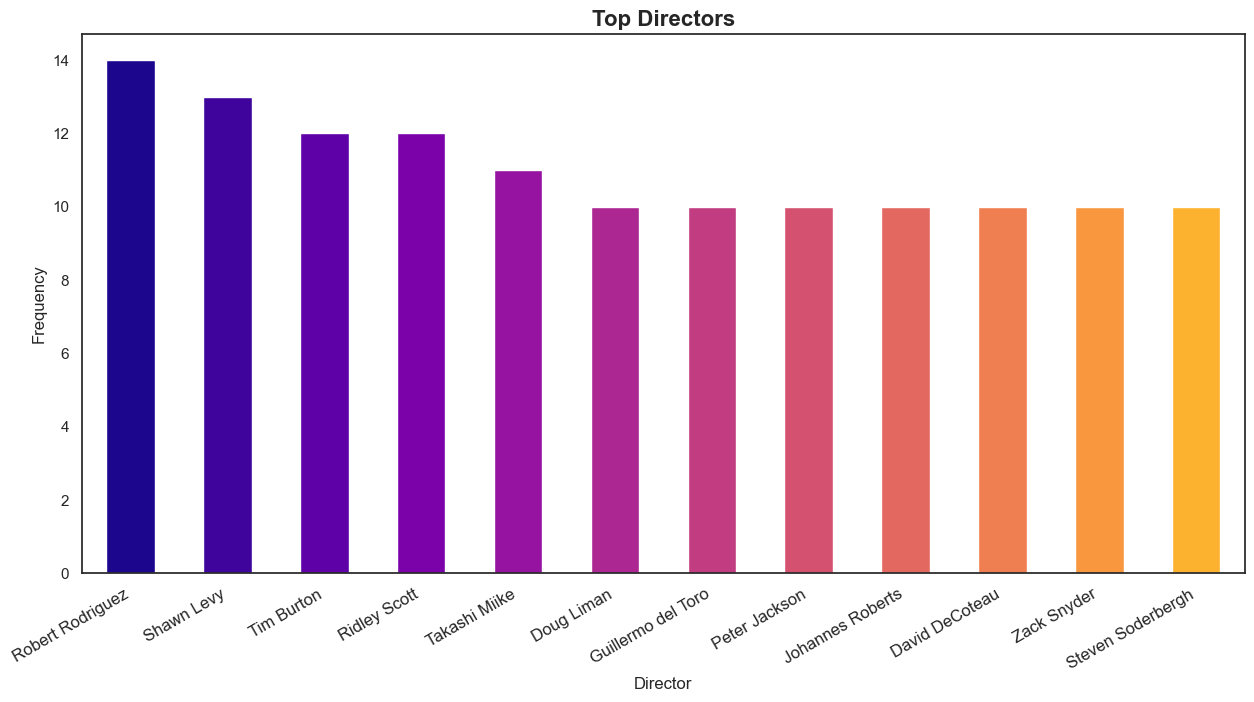

In [85]:
plt.figure(figsize=(15, 7))
top_directors.plot.bar(color = colorpalette[::3], linewidth=1)
plt.title("Top Directors", fontweight="bold", fontsize=16)
plt.xlabel("Director")
plt.ylabel("Frequency")
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.show()